In [693]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as plt

In [694]:
def shortenPath(path, withSide):
    '''
    Takes in a Path and reduces it to its Fast Assembly Line number,
    its island number, and its ABL side.

    @param Path is the path which we want to reduce
    @param withSide is a boolean for if we want to include the UF, RH, or LF of the path
    @return the shortened path
    '''

    #split path into its components and label indexs for each component
    split_path = path.split("\\")
    index_of_fast_line_number = 3
    index_of_island_number = 4
    index_of_ABL_side = 5

    #build reduced path from desired compoents
    if withSide:        
        reduced_path =  split_path[index_of_fast_line_number]  + \
        split_path[index_of_island_number] + \
        split_path[index_of_ABL_side].split(" ")[0]
    else: 
        reduced_path =  split_path[index_of_fast_line_number]  + \
        split_path[index_of_island_number] + \
        split_path[index_of_ABL_side].split("|")[0]
    return reduced_path

In [695]:
def createDatetime(strDatetime):
    '''
    Given a date and a time in string fomat, returns the data as time as a datetime object
    '''
    #breaks the inputed time and date into an element where each element stores a unit of time or date.
    input = strDatetime.split(" ")
    splitDate = input[0].split("-")
    splitTime = input[1].split(":")

    #returns the input as a datetime object by inputing the date and time elements into the datetime constructor.
    return datetime(int(splitDate[0]), int(splitDate[1]), int(splitDate[2]), 
                    int(splitTime[0]), int(splitTime[1]), int(float(splitTime[2])))


print(type(createDatetime("2024-07-09 00:11:04.303009")))

<class 'datetime.datetime'>


In [700]:
def getYieldDf(df):
    '''
    Given a data frame returns a new dataframe with the count and frequency of each code

    @param df is the data frame we want to get the frequency and count from.
    @return the new data frame with out and frequency.
    '''

    frequency_df = df.copy().groupby("Reject Code").count()
    frequency_df.drop(columns = ["Original ABL Path", "Subcomp_Lot_ID", "Reduced Path", "Original Rack Path"], inplace = True)
    frequency_df.rename(columns = {"Timestamp": "Count"}, inplace = True)
    frequency_df.sort_values(by = "Count", ascending = True, inplace = True)
    frequency_df["Yield"] = frequency_df.get("Count") / df.shape[0]

    return frequency_df

In [701]:

# Define data types for columns
types = {
    "Timestamp": str,
    "Value": str,
    "Path": str
}

#Read CSV files
LH_ABL = pd.read_csv("LH_ABL Sx RejectCode_07-16-2024-07-09-2024.csv")
RH_ABL = pd.read_csv("RH_ABL Sx RejectCode_07-16-2024-07-09-2024.csv")
Rack_Subcomp_Lot_ID = pd.read_csv("UF Rack_Lot ID_07-16-2024-07-09-2024.csv", dtype = types)

#combind left and right side of ABL process
ABL = pd.concat([RH_ABL,LH_ABL])


#Turning Data and Time in data frames from String to DateTime object for easy comparison between dates
ABL["Timestamp"] = ABL.get("Timestamp").apply(createDatetime)
Rack_Subcomp_Lot_ID["Timestamp"] = Rack_Subcomp_Lot_ID.get("Timestamp").apply(createDatetime)


#reduce ABL and Rack_Subcomp_Lot_ID Path so that they could be merged
ABL["Reduced Path"] = ABL.get("Path").apply(lambda x: shortenPath(x,False))
ABL["Path"] = ABL.get("Path").apply(lambda x: shortenPath(x,True))
Rack_Subcomp_Lot_ID["Reduced Path"] = Rack_Subcomp_Lot_ID.get("Path").apply(lambda x: shortenPath(x,False))


In [702]:
first_path = ABL.get("Reduced Path").iloc[0]
times_with_matching_reduced_path = Rack_Subcomp_Lot_ID[Rack_Subcomp_Lot_ID.get("Reduced Path") == first_path]
times_with_matching_reduced_path


path_names = Rack_Subcomp_Lot_ID.groupby("Reduced Path").count().index.to_series().array
path_names



#sort ABL and Rack_Subcomp_Lot_ID dataframes by Timestamp for merge in next cell
Rack_Subcomp_Lot_ID = Rack_Subcomp_Lot_ID.sort_values(by = "Timestamp", ascending = True)
ABL = ABL.sort_values(by = "Timestamp", ascending = True)

#rename Value to Subcomp_Lot_ID to differentiated Value in Rack Subcomp_Lot_ID and ABL
Rack_Subcomp_Lot_ID = Rack_Subcomp_Lot_ID.rename(columns = {"Value": "Subcomp_Lot_ID"})

#remove Timestamps in Rack_Subcomp_Lot_ID without an Subcomp_Lot_ID
Rack_Subcomp_Lot_ID = Rack_Subcomp_Lot_ID[Rack_Subcomp_Lot_ID.get("Subcomp_Lot_ID").notna()]



#seperating Rack_Subcomp_Lot_ID and ABL dataframes into distinct paths by line and ABL
FASTr1_ABL1_RACK_Subcomp_Lot_ID = Rack_Subcomp_Lot_ID[Rack_Subcomp_Lot_ID.get("Reduced Path") == "FASTr 1Island 102a-ABL1"]
FASTr1_ABL2_RACK_Subcomp_Lot_ID = Rack_Subcomp_Lot_ID[Rack_Subcomp_Lot_ID.get("Reduced Path") == "FASTr 1Island 102b-ABL2"]
FASTr3_ABL1_RACK_Subcomp_Lot_ID = Rack_Subcomp_Lot_ID[Rack_Subcomp_Lot_ID.get("Reduced Path") == "FASTr 3Island 102a-ABL1"]
FASTr3_ABL2_RACK_Subcomp_Lot_ID = Rack_Subcomp_Lot_ID[Rack_Subcomp_Lot_ID.get("Reduced Path") == "FASTr 3Island 102b-ABL2"]

FASTr1_ABL1_ABL = ABL[ABL.get("Reduced Path") == "FASTr 1Island 102a-ABL1"]
FASTr1_ABL2_ABL = ABL[ABL.get("Reduced Path") == "FASTr 1Island 102b-ABL2"]
FASTr3_ABL1_ABL = ABL[ABL.get("Reduced Path") == "FASTr 3Island 102a-ABL1"]
FASTr3_ABL2_ABL = ABL[ABL.get("Reduced Path") == "FASTr 3Island 102b-ABL2"]


In [703]:
#merging dataframes by timestamp for each line and ABL
merged_FASTr1_ABL1 = (pd.merge_asof(FASTr1_ABL1_ABL, FASTr1_ABL1_RACK_Subcomp_Lot_ID, on="Timestamp", direction="backward")) 
merged_FASTr1_ABL2 = (pd.merge_asof(FASTr1_ABL2_ABL, FASTr1_ABL2_RACK_Subcomp_Lot_ID, on="Timestamp", direction="backward")) 
merged_FASTr3_ABL1 = (pd.merge_asof(FASTr3_ABL1_ABL, FASTr3_ABL1_RACK_Subcomp_Lot_ID, on="Timestamp", direction="backward")) 
merged_FASTr3_ABL2 = (pd.merge_asof(FASTr3_ABL2_ABL, FASTr3_ABL2_RACK_Subcomp_Lot_ID, on="Timestamp", direction="backward")) 

#rename and drop columns after merge for clarity
merged_FASTr1_ABL1.drop(columns = {"Reduced Path_y"}, inplace = True)
merged_FASTr1_ABL2.drop(columns = {"Reduced Path_y"}, inplace = True)
merged_FASTr3_ABL1.drop(columns = {"Reduced Path_y"}, inplace = True)
merged_FASTr3_ABL2.drop(columns = {"Reduced Path_y"}, inplace = True)

merged_FASTr1_ABL1.rename(columns = {"Value": "Reject Code",
                                     "Path_x": "Original ABL Path", 
                                     "Reduced Path_x": "Reduced Path",
                                     "Path_y": "Original Rack Path"}, 
                          inplace = True)

merged_FASTr1_ABL2.rename(columns = {"Value": "Reject Code",
                                     "Path_x": "Original ABL Path", 
                                     "Reduced Path_x": "Reduced Path",
                                     "Path_y": "Original Rack Path"}, 
                          inplace = True)

merged_FASTr3_ABL1.rename(columns = {"Value": "Reject Code",
                                     "Path_x": "Original ABL Path", 
                                     "Reduced Path_x": "Reduced Path",
                                     "Path_y": "Original Rack Path"}, 
                          inplace = True)

merged_FASTr3_ABL2.rename(columns = {"Value": "Reject Code",
                                     "Path_x": "Original ABL Path", 
                                     "Reduced Path_x": "Reduced Path",
                                     "Path_y": "Original Rack Path"}, 
                          inplace = True)


#remove Data which we do not have a matching Subcomp_Lot_ID
merged_FASTr1_ABL1 = merged_FASTr1_ABL1[merged_FASTr1_ABL1.get("Subcomp_Lot_ID").notna()]
merged_FASTr1_ABL2 = merged_FASTr1_ABL2[merged_FASTr1_ABL2.get("Subcomp_Lot_ID").notna()]
merged_FASTr3_ABL1 = merged_FASTr3_ABL1[merged_FASTr3_ABL1.get("Subcomp_Lot_ID").notna()]
merged_FASTr3_ABL2 = merged_FASTr3_ABL2[merged_FASTr3_ABL2.get("Subcomp_Lot_ID").notna()]

#add all dataframes from different paths into one large dataframe
merged_all_data = pd.concat([merged_FASTr1_ABL1, merged_FASTr1_ABL2, merged_FASTr3_ABL1, merged_FASTr3_ABL2])

#For each line and ABL separate each dataframe into their left and right ABL components
merged_FASTr1_ABL1_RH = merged_FASTr1_ABL1[merged_FASTr1_ABL1.get("Original ABL Path").str.contains("RH")]
merged_FASTr1_ABL1_LH = merged_FASTr1_ABL1[merged_FASTr1_ABL1.get("Original ABL Path").str.contains("LH")]

merged_FASTr1_ABL2_RH = merged_FASTr1_ABL2[merged_FASTr1_ABL2.get("Original ABL Path").str.contains("RH")]
merged_FASTr1_ABL2_LH = merged_FASTr1_ABL2[merged_FASTr1_ABL2.get("Original ABL Path").str.contains("LH")]

merged_FASTr3_ABL1_RH = merged_FASTr3_ABL1[merged_FASTr3_ABL1.get("Original ABL Path").str.contains("RH")]
merged_FASTr3_ABL1_LH = merged_FASTr3_ABL1[merged_FASTr3_ABL1.get("Original ABL Path").str.contains("LH")]

merged_FASTr3_ABL2_RH = merged_FASTr3_ABL2[merged_FASTr3_ABL2.get("Original ABL Path").str.contains("RH")]
merged_FASTr3_ABL2_LH = merged_FASTr3_ABL2[merged_FASTr3_ABL2.get("Original ABL Path").str.contains("LH")]


#controlls how much of the dataframe is displayed in jupyter notebook
#pd.set_option('display.max_rows', None)
#pd.reset_option("display.max_rows")
#pd.reset_option("display.max_columns")


#group by Reject code to calcalute yeild for each lot
merged_FASTr1_ABL1_RH_Reject = getYieldDf(merged_FASTr1_ABL1_RH)
merged_FASTr1_ABL1_LH_Reject = getYieldDf(merged_FASTr1_ABL1_LH)

merged_FASTr1_ABL2_RH_Reject = getYieldDf(merged_FASTr1_ABL2_RH)
merged_FASTr1_ABL2_LH_Reject = getYieldDf(merged_FASTr1_ABL2_LH)

merged_FASTr3_ABL1_RH_Reject = getYieldDf(merged_FASTr3_ABL1_RH)
merged_FASTr3_ABL1_LH_Reject = getYieldDf(merged_FASTr3_ABL1_LH)

merged_FASTr3_ABL2_RH_Reject = getYieldDf(merged_FASTr3_ABL2_RH)
merged_FASTr3_ABL2_LH_Reject = getYieldDf(merged_FASTr3_ABL2_LH)

#Query only the pass yield for each group

#Query pass for Fastr 1 ABL 1 LH and RH
FASTr_1_ABL_1_RH_pass_yield = merged_FASTr1_ABL1_RH_Reject[merged_FASTr1_ABL1_RH_Reject.index == "Pass"]
FASTr_1_ABL_1_LH_pass_yield = merged_FASTr1_ABL1_LH_Reject[merged_FASTr1_ABL1_LH_Reject.index == "Pass"]

#Query pass for Fastr 1 ABL 2 LH and RH
FASTr_1_ABL_2_RH_pass_yield = merged_FASTr1_ABL2_RH_Reject[merged_FASTr1_ABL2_RH_Reject.index == "Pass"]
FASTr_1_ABL_2_LH_pass_yield = merged_FASTr1_ABL2_LH_Reject[merged_FASTr1_ABL2_LH_Reject.index == "Pass"]

#Query pass for Fastr 3 ABL 1 LH and RH
FASTr_3_ABL_1_RH_pass_yield = merged_FASTr3_ABL1_RH_Reject[merged_FASTr3_ABL1_RH_Reject.index == "Pass"]
FASTr_3_ABL_1_LH_pass_yield = merged_FASTr3_ABL1_LH_Reject[merged_FASTr3_ABL1_LH_Reject.index == "Pass"]

#Query pass for Fastr 3 ABL 2 LH and RH
FASTr_3_ABL_2_RH_pass_yield = merged_FASTr3_ABL2_RH_Reject[merged_FASTr3_ABL2_RH_Reject.index == "Pass"]
FASTr_3_ABL_2_LH_pass_yield = merged_FASTr3_ABL2_LH_Reject[merged_FASTr3_ABL2_LH_Reject.index == "Pass"]


Count     Yield
FASTr_1_ABL_1_RH_pass_yield  14775  0.897903
FASTr_1_ABL_1_LH_pass_yield  14781  0.887215
FASTr_1_ABL_2_RH_pass_yield  15486  0.946924
FASTr_1_ABL_2_LH_pass_yield  15473  0.966881
FASTr_3_ABL_1_RH_pass_yield  33324  0.967427
FASTr_3_ABL_1_LH_pass_yield  33308  0.960660
FASTr_3_ABL_2_RH_pass_yield  32192  0.953018
FASTr_3_ABL_2_LH_pass_yield  32135  0.965276

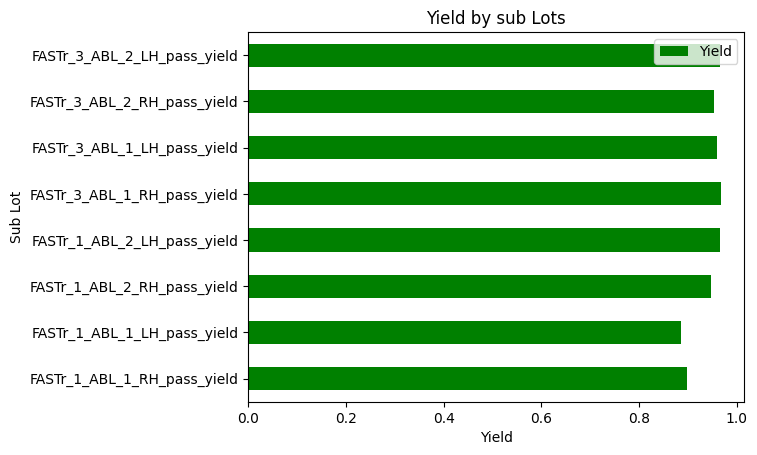

In [704]:
#Add Yield Rate into one data frame

equipment_yield = pd.concat([pd.DataFrame(), FASTr_1_ABL_1_RH_pass_yield])
equipment_yield = pd.concat([equipment_yield, FASTr_1_ABL_1_LH_pass_yield])

equipment_yield = pd.concat([equipment_yield, FASTr_1_ABL_2_RH_pass_yield])
equipment_yield = pd.concat([equipment_yield, FASTr_1_ABL_2_LH_pass_yield])

equipment_yield = pd.concat([equipment_yield, FASTr_3_ABL_1_RH_pass_yield])
equipment_yield = pd.concat([equipment_yield, FASTr_3_ABL_1_LH_pass_yield])

equipment_yield = pd.concat([equipment_yield, FASTr_3_ABL_2_RH_pass_yield])
equipment_yield = pd.concat([equipment_yield, FASTr_3_ABL_2_LH_pass_yield])




#rename Value index to match where each count and yeild is from
equipment_yield.index = ["FASTr_1_ABL_1_RH_pass_yield",
                         "FASTr_1_ABL_1_LH_pass_yield", 
                         "FASTr_1_ABL_2_RH_pass_yield", 
                         "FASTr_1_ABL_2_LH_pass_yield",
                         "FASTr_3_ABL_1_RH_pass_yield",
                         "FASTr_3_ABL_1_LH_pass_yield",
                         "FASTr_3_ABL_2_RH_pass_yield",
                         "FASTr_3_ABL_2_LH_pass_yield"]


equipment_yield.plot(
    kind="barh",
    y= "Yield",
    color= "Green",
    fontsize=10,
    title="Yield by sub Lots",
    xlabel="Yield",
    ylabel="Sub Lot"
);
equipment_yield


In [705]:
Yield_All_Paths =  pd.DataFrame(index = range(merged_all_data.shape[0]))
# Create a list of column names for yield and count
column_names = [
    "FASTr 1Island 102a-ABL1|LH_ABL_Yield",
    "FASTr 1Island 102a-ABL1|RH_ABL_Yield",
    "FASTr 1Island 102b-ABL2|LH_ABL_Yield",
    "FASTr 1Island 102b-ABL2|RH_ABL_Yield",
    "FASTr 3Island 102a-ABL1|LH_ABL_Yield",
    "FASTr 3Island 102a-ABL1|RH_ABL_Yield",
    "FASTr 3Island 102b-ABL2|LH_ABL_Yield",
    "FASTr 3Island 102b-ABL2|RH_ABL_Yield"
]

column_names_cnt = [
    "FASTr 1Island 102a-ABL1|LH_ABL",
    "FASTr 1Island 102a-ABL1|RH_ABL",
    "FASTr 1Island 102b-ABL2|LH_ABL",
    "FASTr 1Island 102b-ABL2|RH_ABL",
    "FASTr 3Island 102a-ABL1|LH_ABL",
    "FASTr 3Island 102a-ABL1|RH_ABL",
    "FASTr 3Island 102b-ABL2|LH_ABL",
    "FASTr 3Island 102b-ABL2|RH_ABL"
]


# Initialize a dictionary to store the Series
yield_dict = {}
line_count = {}
# Create Series for each column name
for col in column_names:
    yield_dict[col] = pd.Series([0.0] * Yield_All_Paths.shape[0])
    line_count[col] = [0, 0]

for col in column_names_cnt:
    yield_dict[col] = pd.Series([0.0] * Yield_All_Paths.shape[0])

sorted_merged_all_data = merged_all_data.sort_values(by = "Timestamp", ascending = True)

#calculates the yield for each line after every time stamp   do this by interger index acutally
for int_index in range(sorted_merged_all_data.shape[0]):

    path_cnt = sorted_merged_all_data.get("Original ABL Path").iloc[int_index]
    path = path_cnt + "_Yield"
    
    #Check if line passes at this timestamp
    if sorted_merged_all_data.get("Reject Code").iloc[int_index] == "Pass":
        line_count[path][0] = line_count[path][0] + 1
    line_count[path][1] = line_count[path][1] + 1
    
    #upadate the current yield at this timestamp
    yield_dict[path][int_index:] = float(line_count[path][0]) / float(line_count[path][1] + 1)
    #update the current count at this timestamp
    yield_dict[path_cnt][int_index:] = float(line_count[path][0])

time_data = sorted_merged_all_data.get("Timestamp").to_frame().reset_index()

for col in column_names:
    time_data[col] = yield_dict[col]

for col in column_names_cnt:
    time_data[col] = yield_dict[col]

time_data

index           Timestamp  FASTr 1Island 102a-ABL1|LH_ABL_Yield  \
0         146 2024-07-09 00:11:04                              0.000000   
1         147 2024-07-09 00:11:08                              0.000000   
2         148 2024-07-09 00:11:12                              0.000000   
3         149 2024-07-09 00:11:15                              0.000000   
4         150 2024-07-09 00:11:20                              0.000000   
...       ...                 ...                                   ...   
201655  69526 2024-07-15 23:59:47                              0.887162   
201656  67564 2024-07-15 23:59:51                              0.887162   
201657  69527 2024-07-15 23:59:54                              0.887162   
201658  67565 2024-07-15 23:59:54                              0.887162   
201659  67566 2024-07-15 23:59:58                              0.887162   

        FASTr 1Island 102a-ABL1|RH_ABL_Yield  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   
3                                   0.000000   
4                                   0.000000   
...                                      ...   
201655                              0.897849   
201656                              0.897849   
201657                              0.897849   
201658                              0.897849   
201659                              0.897849   

        FASTr 1Island 102b-ABL2|LH_ABL_Yield  \
0                                   0.500000   
1                                   0.500000   
2                                   0.666667   
3                                   0.666667   
4                                   0.750000   
...                                      ...   
201655                              0.966821   
201656                              0.966821   
201657                              0.966821   
201658                              0.966821   
201659                              0.966821   

        FASTr 1Island 102b-ABL2|RH_ABL_Yield  \
0                                   0.000000   
1                                   0.500000   
2                                   0.500000   
3                                   0.666667   
4                                   0.666667   
...                                      ...   
201655                              0.946866   
201656                              0.946866   
201657                              0.946866   
201658                              0.946866   
201659                              0.946866   

        FASTr 3Island 102a-ABL1|LH_ABL_Yield  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   
3                                   0.000000   
4                                   0.000000   
...                                      ...   
201655                              0.960632   
201656                              0.960632   
201657                              0.960632   
201658                              0.960632   
201659                              0.960632   

        FASTr 3Island 102a-ABL1|RH_ABL_Yield  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   
3                                   0.000000   
4                                   0.000000   
...                                      ...   
201655                              0.967398   
201656                              0.967398   
201657                              0.967399   
201658                              0.967399   
201659                              0.967399   

        FASTr 3Island 102b-ABL2|LH_ABL_Yield  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   
3                             

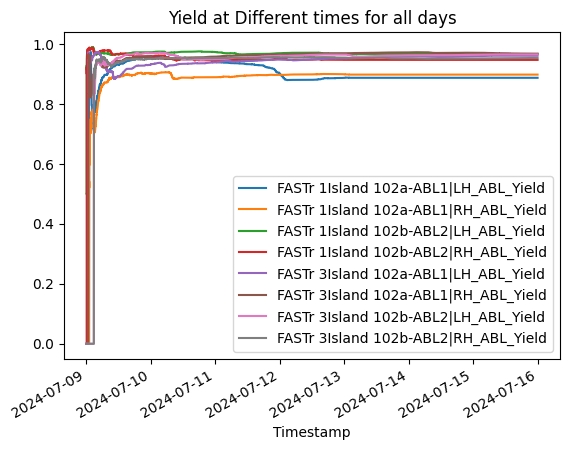

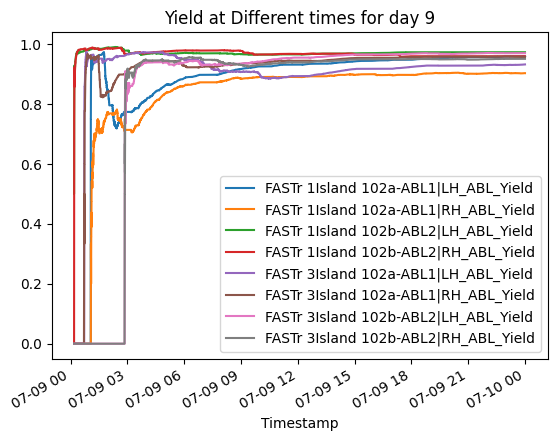

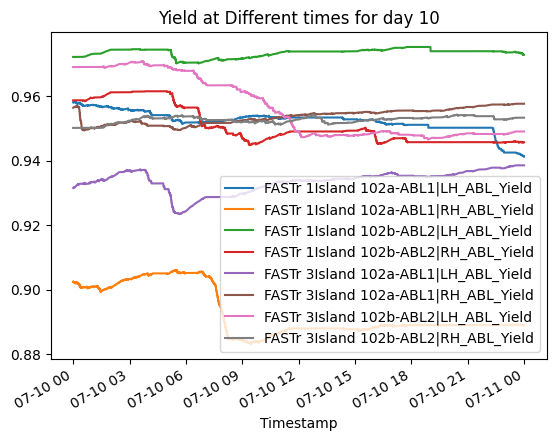

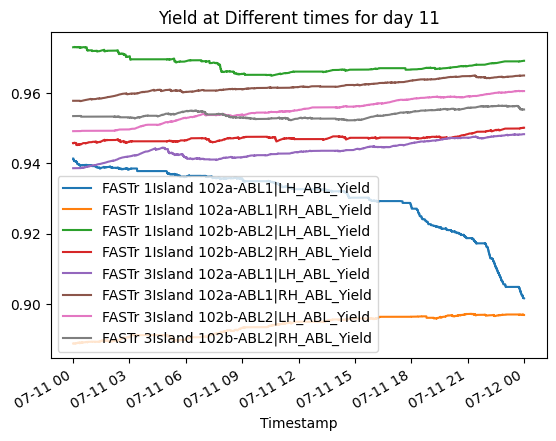

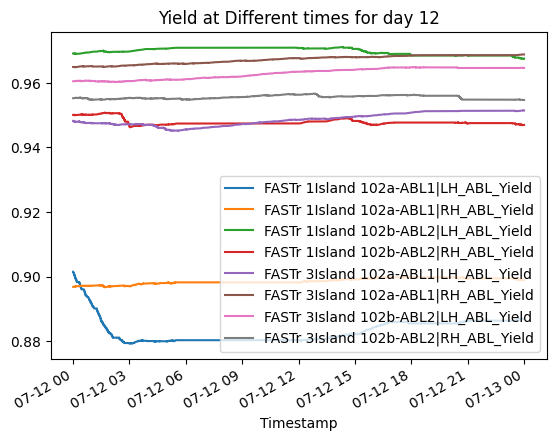

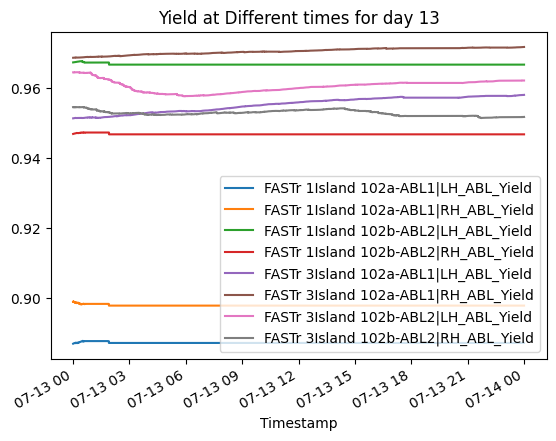

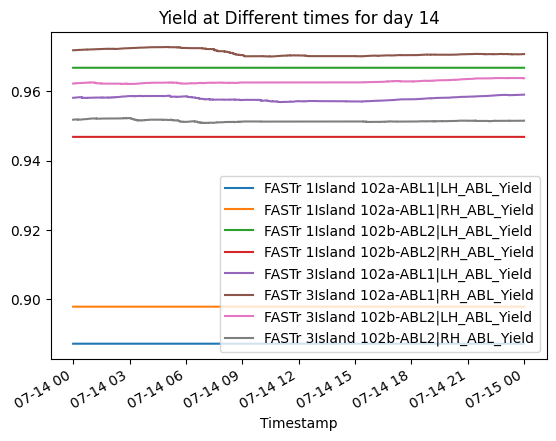

In [706]:

start_day = 9
end_day = 15

#create a dictionary of timedates where specific_time_date[3] = 7/3/24
specific_day = {}
for day in range(start_day, end_day + 1):
    date = datetime(2024, 7, day, 0, 0, 0)
    specific_day[day] = date

#Create dictionary of time_data where each key value pair represents a day:(dataframe of data in that day)
specific_time_data = {}

#Query all time_data by one day intervals
for day in range(start_day, end_day):
    #For each dictionary entry, store a specific day in time_date 
    specific_time_data[day] = time_data[(time_data.get("Timestamp") >=  specific_day[day]) & (time_data.get("Timestamp") <  specific_day[day+1])]

#Plot Yield data for all days
time_data.plot(
    kind = "line", 
    x = "Timestamp", 
    y = [
    "FASTr 1Island 102a-ABL1|LH_ABL_Yield",
    "FASTr 1Island 102a-ABL1|RH_ABL_Yield",
    "FASTr 1Island 102b-ABL2|LH_ABL_Yield",
    "FASTr 1Island 102b-ABL2|RH_ABL_Yield",
    "FASTr 3Island 102a-ABL1|LH_ABL_Yield",
    "FASTr 3Island 102a-ABL1|RH_ABL_Yield",
    "FASTr 3Island 102b-ABL2|LH_ABL_Yield",
    "FASTr 3Island 102b-ABL2|RH_ABL_Yield"],
    title="Yield at Different times for all days",
    fontsize = 10
);


#plot yield data for each day
for day in range(9,15):
    specific_time_data[day].plot(
    kind = "line", 
    x = "Timestamp", 
    y = [
    "FASTr 1Island 102a-ABL1|LH_ABL_Yield",
    "FASTr 1Island 102a-ABL1|RH_ABL_Yield",
    "FASTr 1Island 102b-ABL2|LH_ABL_Yield",
    "FASTr 1Island 102b-ABL2|RH_ABL_Yield",
    "FASTr 3Island 102a-ABL1|LH_ABL_Yield",
    "FASTr 3Island 102a-ABL1|RH_ABL_Yield",
    "FASTr 3Island 102b-ABL2|LH_ABL_Yield",
    "FASTr 3Island 102b-ABL2|RH_ABL_Yield"],
    title="Yield at Different times for day " + str(day),
    fontsize = 10
);

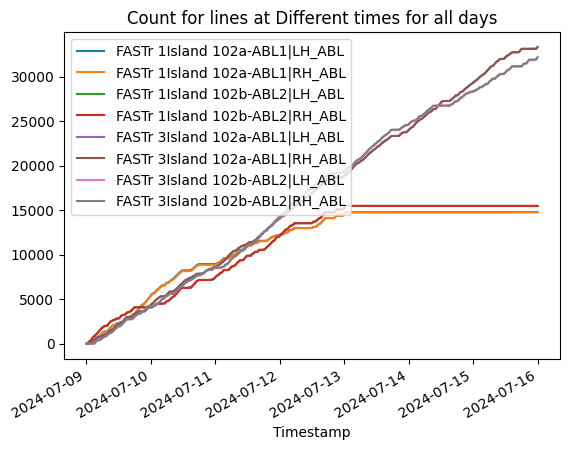

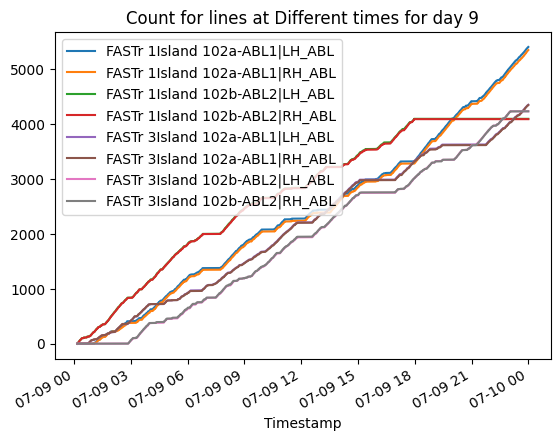

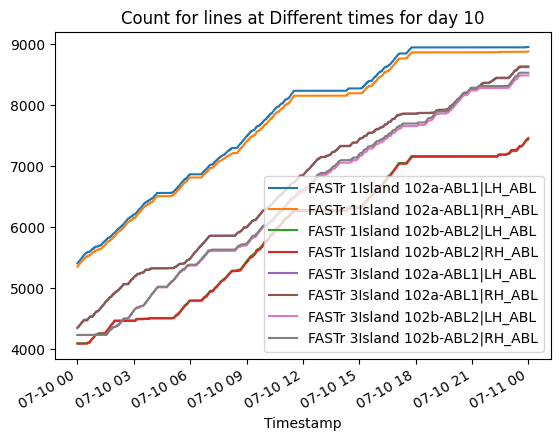

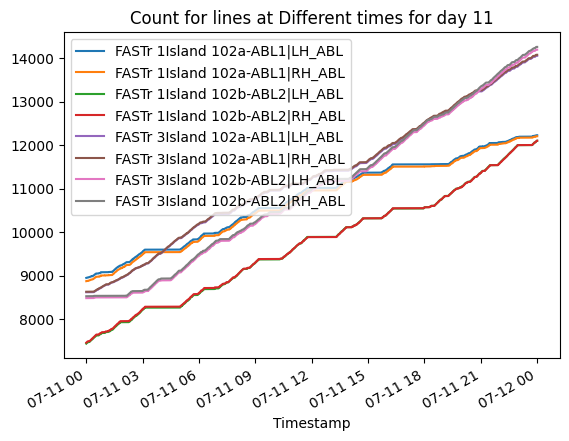

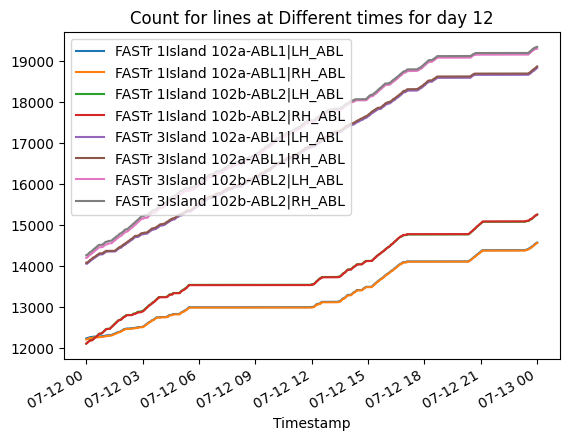

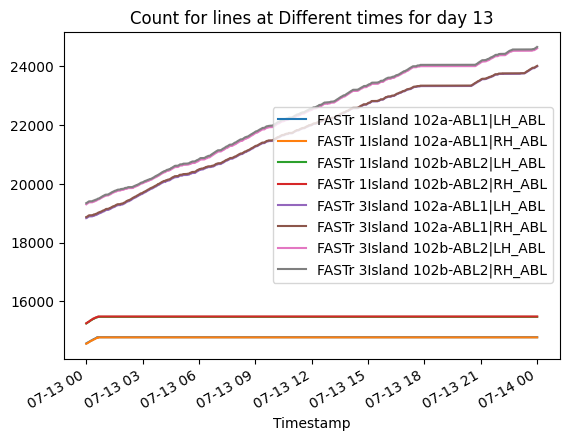

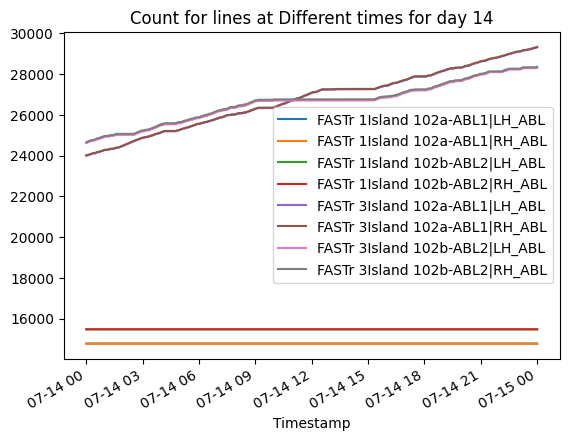

In [707]:
#Plot Count data for all days
time_data.plot(
    kind = "line", 
    x = "Timestamp", 
    y = [
    "FASTr 1Island 102a-ABL1|LH_ABL",
    "FASTr 1Island 102a-ABL1|RH_ABL",
    "FASTr 1Island 102b-ABL2|LH_ABL",
    "FASTr 1Island 102b-ABL2|RH_ABL",
    "FASTr 3Island 102a-ABL1|LH_ABL",
    "FASTr 3Island 102a-ABL1|RH_ABL",
    "FASTr 3Island 102b-ABL2|LH_ABL",
    "FASTr 3Island 102b-ABL2|RH_ABL"],
    title="Count for lines at Different times for all days",
    fontsize = 10
);


#plot count data for each day
for day in range(9,15):
    specific_time_data[day].plot(
    kind = "line", 
    x = "Timestamp", 
    y = [
    "FASTr 1Island 102a-ABL1|LH_ABL",
    "FASTr 1Island 102a-ABL1|RH_ABL",
    "FASTr 1Island 102b-ABL2|LH_ABL",
    "FASTr 1Island 102b-ABL2|RH_ABL",
    "FASTr 3Island 102a-ABL1|LH_ABL",
    "FASTr 3Island 102a-ABL1|RH_ABL",
    "FASTr 3Island 102b-ABL2|LH_ABL",
    "FASTr 3Island 102b-ABL2|RH_ABL"],
    title="Count for lines at Different times for day " + str(day),
    fontsize = 10
);

RH Count  RH Yield  LH Count  LH Yield
FASTr_1_ABL_1     14775  0.897903     14781  0.887215
FASTr_1_ABL_2     15486  0.946924     15473  0.966881
FASTr_3_ABL_1     33324  0.967427     33308  0.960660
FASTr_3_ABL_2     32192  0.953018     32135  0.965276

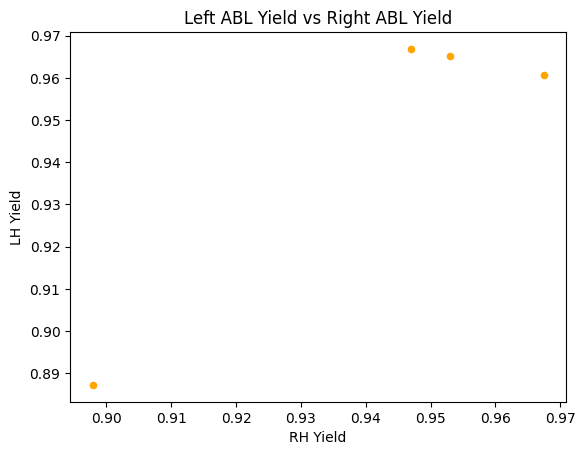

In [709]:
# Filter rows into right and left half of ABL
equipment_yield_RH = equipment_yield.copy()[equipment_yield.index.str.contains("RH")]
equipment_yield_LH = equipment_yield.copy()[equipment_yield.index.str.contains("LH")]

#rename column right and left ABL names 
equipment_yield_RH.rename(columns = {"Yield": "RH Yield"}, inplace = True)
equipment_yield_RH.rename(columns = {"Count": "RH Count"}, inplace = True)
equipment_yield_LH.rename(columns = {"Yield": "LH Yield"}, inplace = True)
equipment_yield_LH.rename(columns = {"Count": "LH Count"}, inplace = True)

#Rename indexs to match the change where RH and LH are represented in different columns
equipment_yield_RH.index = ["FASTr_1_ABL_1", 
                            "FASTr_1_ABL_2", 
                            "FASTr_3_ABL_1", 
                            "FASTr_3_ABL_2"]

equipment_yield_LH.index = ["FASTr_1_ABL_1", 
                            "FASTr_1_ABL_2", 
                            "FASTr_3_ABL_1", 
                            "FASTr_3_ABL_2"]

#Combind filtered rows together into one data frame for scatter plot graphing
equipment_yield_both = pd.concat([equipment_yield_RH, equipment_yield_LH], axis = 1)
equipment_yield_both

#plot scatter plot to see if there is relationship between right and left ABL yield
equipment_yield_both.plot(
    kind = "scatter", 
    x = "RH Yield", 
    y = "LH Yield",
    color= "orange",
    title="Left ABL Yield vs Right ABL Yield",
);

equipment_yield_both

Count     Yield
Difference_FASTr_1_ABL_1     -6  0.010688
Difference_FASTr_1_ABL_2     13 -0.019957
Difference_FASTr_3_ABL_1     16  0.006767
Difference_FASTr_3_ABL_2     57 -0.012258

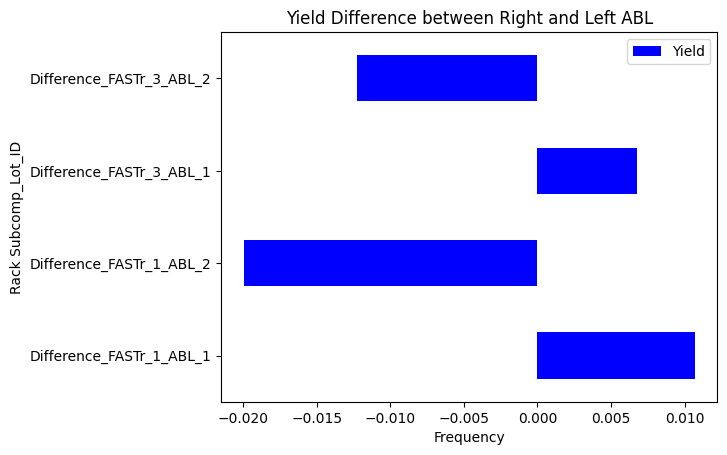

In [737]:
#Calutate the Difference between the Right and Left Half of the ABL process for each line
Difference_FASTr_1_ABL_1 = FASTr_1_ABL_1_RH_pass_yield - FASTr_1_ABL_1_LH_pass_yield
Difference_FASTr_1_ABL_2 = FASTr_1_ABL_2_RH_pass_yield - FASTr_1_ABL_2_LH_pass_yield
Difference_FASTr_3_ABL_1 = FASTr_3_ABL_1_RH_pass_yield - FASTr_3_ABL_1_LH_pass_yield
Difference_FASTr_3_ABL_2 = FASTr_3_ABL_2_RH_pass_yield - FASTr_3_ABL_2_LH_pass_yield

#Add the differnces into a dataframe
yield_differnce = pd.concat([pd.DataFrame(), Difference_FASTr_1_ABL_1])
yield_differnce = pd.concat([yield_differnce, Difference_FASTr_1_ABL_2])
yield_differnce = pd.concat([yield_differnce, Difference_FASTr_3_ABL_1])
yield_differnce = pd.concat([yield_differnce, Difference_FASTr_3_ABL_2])

#Rename name of the index to the Differnce Lines
yield_differnce.index = ["Difference_FASTr_1_ABL_1",
                         "Difference_FASTr_1_ABL_2", 
                         "Difference_FASTr_3_ABL_1", 
                         "Difference_FASTr_3_ABL_2"]
#Plot the differences
yield_differnce.plot(
    kind="barh",
    y= "Yield",
    color= "Blue",
    fontsize=10,
    title="Yield Difference between Right and Left ABL",
    xlabel="Frequency",
    ylabel="Rack Subcomp_Lot_ID"
);

yield_differnce

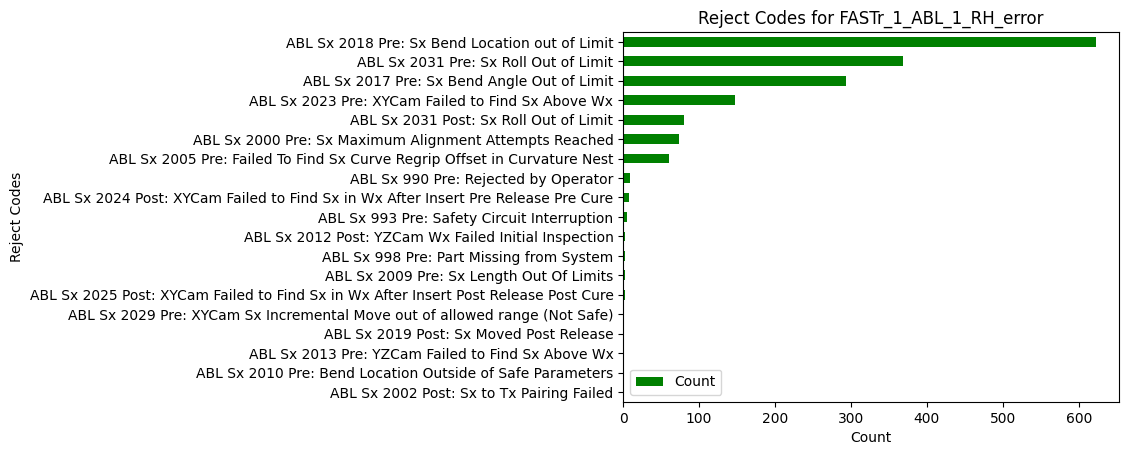

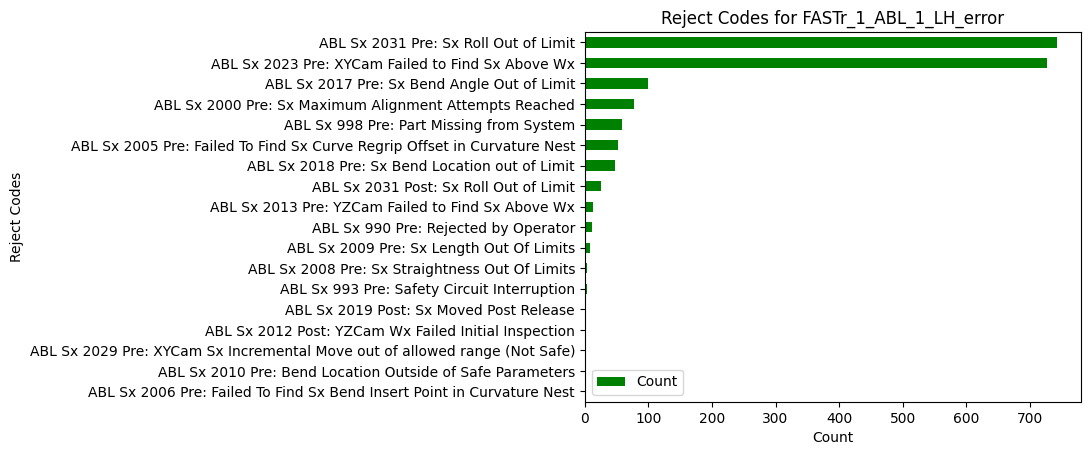

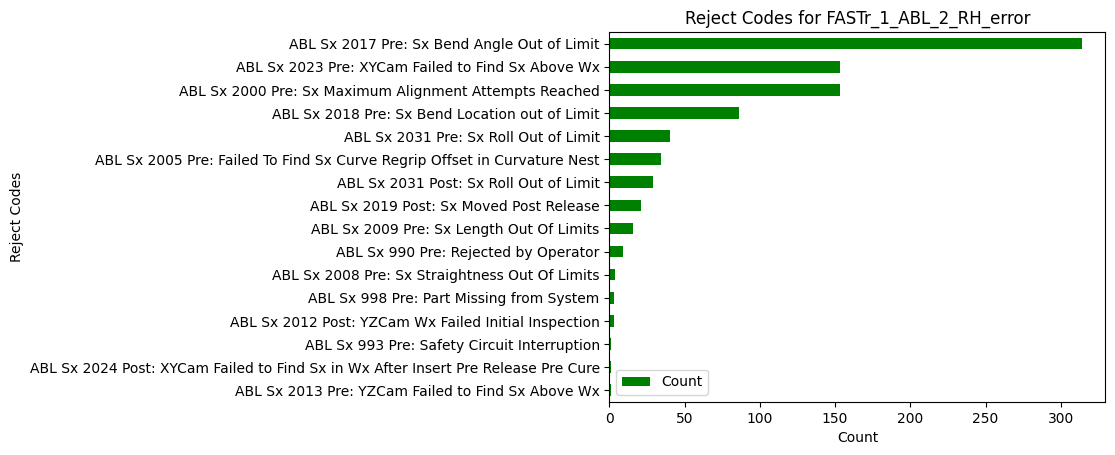

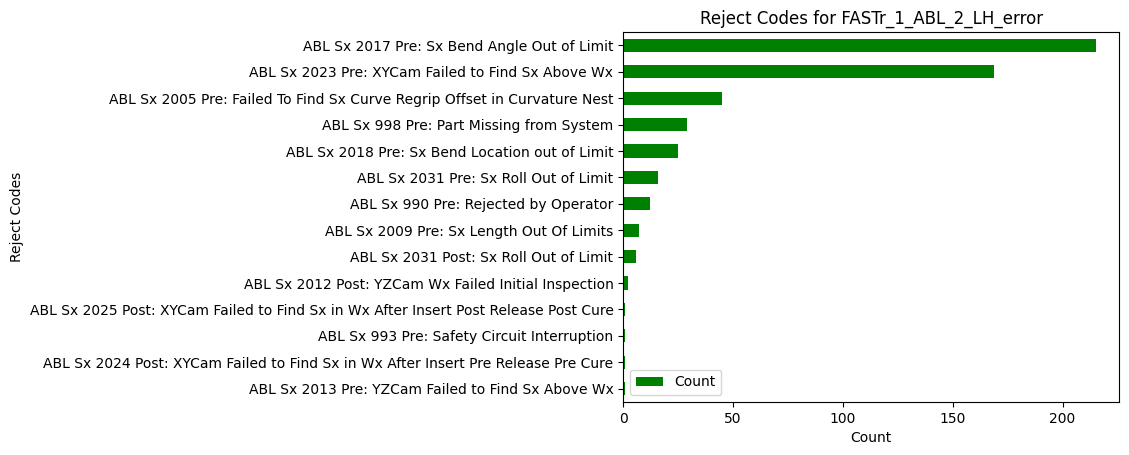

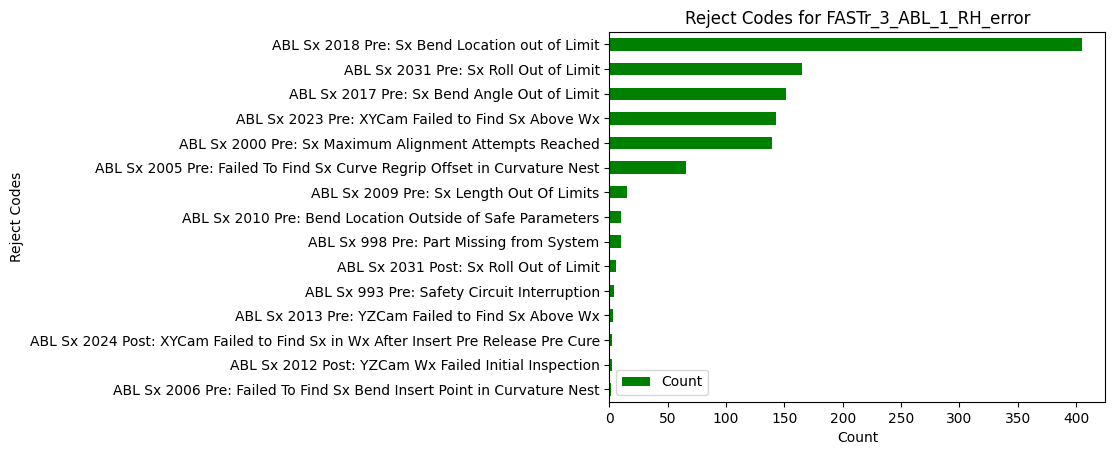

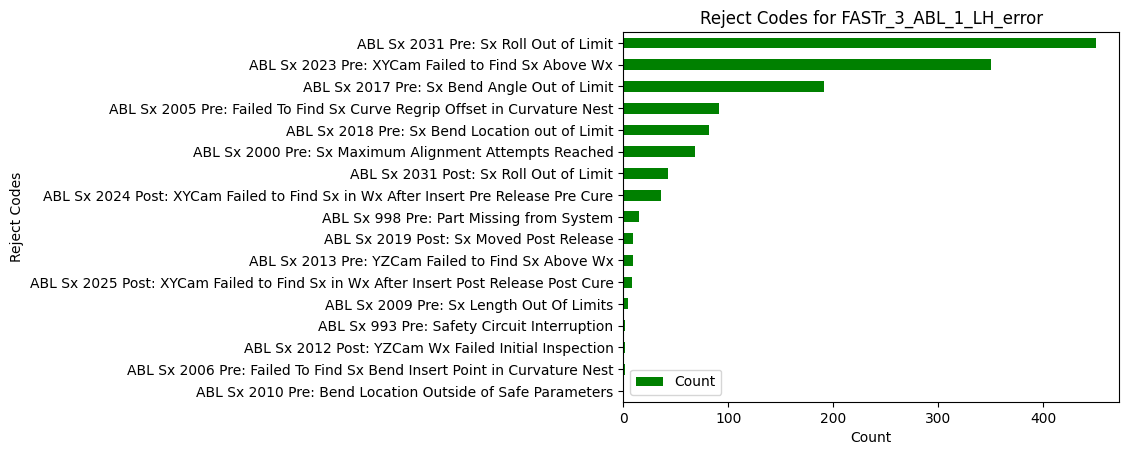

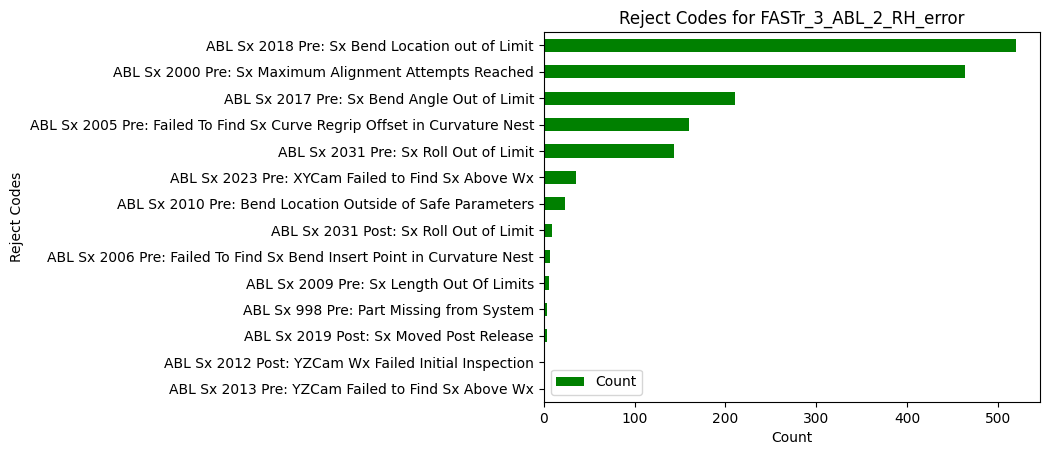

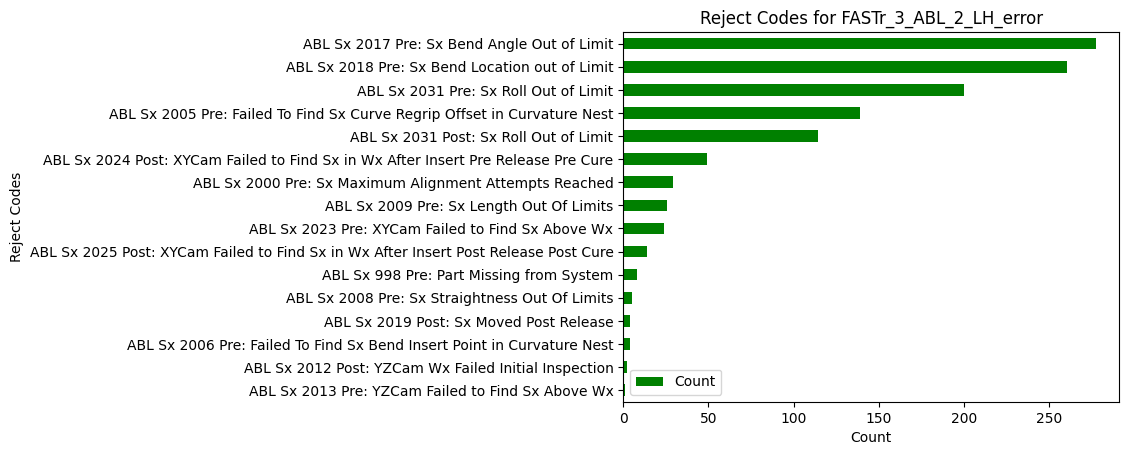

In [738]:
#Query for error codes for Fastr 1 ABL 1 LH and RH
FASTr_1_ABL_1_RH_error = merged_FASTr1_ABL1_RH_Reject[merged_FASTr1_ABL1_RH_Reject.index != "Pass"]
FASTr_1_ABL_1_LH_error = merged_FASTr1_ABL1_LH_Reject[merged_FASTr1_ABL1_LH_Reject.index != "Pass"]

#Query pass for Fastr 1 ABL 2 LH and RH
FASTr_1_ABL_2_RH_error = merged_FASTr1_ABL2_RH_Reject[merged_FASTr1_ABL2_RH_Reject.index != "Pass"]
FASTr_1_ABL_2_LH_error = merged_FASTr1_ABL2_LH_Reject[merged_FASTr1_ABL2_LH_Reject.index != "Pass"]

#Query pass for Fastr 3 ABL 1 LH and RH
FASTr_3_ABL_1_RH_error = merged_FASTr3_ABL1_RH_Reject[merged_FASTr3_ABL1_RH_Reject.index != "Pass"]
FASTr_3_ABL_1_LH_error = merged_FASTr3_ABL1_LH_Reject[merged_FASTr3_ABL1_LH_Reject.index != "Pass"]

#Query pass for Fastr 3 ABL 2 LH and RH
FASTr_3_ABL_2_RH_error = merged_FASTr3_ABL2_RH_Reject[merged_FASTr3_ABL2_RH_Reject.index != "Pass"]
FASTr_3_ABL_2_LH_error = merged_FASTr3_ABL2_LH_Reject[merged_FASTr3_ABL2_LH_Reject.index != "Pass"]


#Add Yield Rate into one data frame

equipment_error = pd.concat([pd.DataFrame(), FASTr_1_ABL_1_RH_error])
equipment_error = pd.concat([equipment_error, FASTr_1_ABL_1_LH_error])

equipment_error = pd.concat([equipment_error, FASTr_1_ABL_2_RH_error])
equipment_error = pd.concat([equipment_error, FASTr_1_ABL_2_LH_error])

equipment_error = pd.concat([equipment_error, FASTr_3_ABL_1_RH_error])
equipment_error = pd.concat([equipment_error, FASTr_3_ABL_1_LH_error])

equipment_error = pd.concat([equipment_error, FASTr_3_ABL_2_RH_error])
equipment_error = pd.concat([equipment_error, FASTr_3_ABL_2_LH_error])

error_array = [FASTr_1_ABL_1_RH_error,
              FASTr_1_ABL_1_LH_error,
              FASTr_1_ABL_2_RH_error,
              FASTr_1_ABL_2_LH_error,
              FASTr_3_ABL_1_RH_error,
              FASTr_3_ABL_1_LH_error,
              FASTr_3_ABL_2_RH_error,
              FASTr_3_ABL_2_LH_error]

error_array_names = ["FASTr_1_ABL_1_RH_error",
              "FASTr_1_ABL_1_LH_error",
              "FASTr_1_ABL_2_RH_error",
              "FASTr_1_ABL_2_LH_error",
              "FASTr_3_ABL_1_RH_error",
              "FASTr_3_ABL_1_LH_error",
              "FASTr_3_ABL_2_RH_error",
              "FASTr_3_ABL_2_LH_error"]


for int_index in range(len(error_array)):
    error_array[int_index].plot(
    kind="barh",
    y= "Count",
    color= "Green",
    fontsize=10,
    title="Reject Codes for " + error_array_names[int_index],
    xlabel="Count",
    ylabel="Reject Codes"
);


Count  \
ID      Status Code                                                 
7350150 ABL Sx 2000 Pre: Sx Maximum Alignment Attempts ...     10   
        ABL Sx 2005 Pre: Failed To Find Sx Curve Regrip...     18   
        ABL Sx 2006 Pre: Failed To Find Sx Bend Insert ...      1   
        ABL Sx 2009 Pre: Sx Length Out Of Limits                1   
        ABL Sx 2012 Post: YZCam Wx Failed Initial Inspe...      1   
...                                                           ...   
7351544 ABL Sx 2031 Post: Sx Roll Out of Limit                 17   
        ABL Sx 2031 Pre: Sx Roll Out of Limit                  97   
        ABL Sx 993 Pre: Safety Circuit Interruption             1   
        ABL Sx 998 Pre: Part Missing from System                3   
        Pass                                                22984   

                                                            Original ABL Path  \
ID      Status Code                                                             
7350150 ABL Sx 2000 Pre: Sx Maximum Alignment Attempts ...                 10   
        ABL Sx 2005 Pre: Failed To Find Sx Curve Regrip...                 18   
        ABL Sx 2006 Pre: Failed To Find Sx Bend Insert ...                  1   
        ABL Sx 2009 Pre: Sx Length Out Of Limits                            1   
        ABL Sx 2012 Post: YZCam Wx Failed Initial Inspe...                  1   
...                                                                       ...   
7351544 ABL Sx 2031 Post: Sx Roll Out of Limit                             17   
        ABL Sx 2031 Pre: Sx Roll Out of Limit                              97   
        ABL Sx 993 Pre: Safety Circuit Interruption                         1   
        ABL Sx 998 Pre: Part Missing from System                            3   
        Pass                                                            22984   

                                                            Reduced Path  \
ID      Status Code                                                        
7350150 ABL Sx 2000 Pre: Sx Maximum Alignment Attempts ...            10   
        ABL Sx 2005 Pre: Failed To Find Sx Curve Regrip...            18   
        ABL Sx 2006 Pre: Failed To Find Sx Bend Insert ...             1   
        ABL Sx 2009 Pre: Sx Length Out Of Limits                       1   
        ABL Sx 2012 Post: YZCam Wx Failed Initial Inspe...             1   
...                                                                  ...   
7351544 ABL Sx 2031 Post: Sx Roll Out of Limit                        17   
        ABL Sx 2031 Pre: Sx Roll Out of Limit                         97   
        ABL Sx 993 Pre: Safety Circuit Interruption                    1   
        ABL Sx 998 Pre: Part Missing from System                       3   
        Pass                                                       22984   

                                                            Original Rack Path  
ID      Status Code                                                             
7350150 ABL Sx 2000 Pre: Sx Maximum Alignment Attempts ...                  10  
        ABL Sx 2005 Pre: Failed To Find Sx Curve Regrip...                  18  
        ABL Sx 2006 Pre: Failed To Find Sx Bend Insert ...                   1  
        ABL Sx 2009 Pre: Sx Length Out Of Limits                             1  
        ABL Sx 2012 Post: YZCam Wx Failed Initial Inspe...                   1  
...                                                                        ...  
7351544 ABL Sx 2031 Post: Sx Roll Out of Limit                              17  
        ABL Sx 2031 Pre: Sx Roll Out of Limit                               97  
        ABL Sx 993 Pre: Safety Circuit Interruption                          1  
        ABL Sx 998 Pre: Part Missing from System                             3  
        Pass                                                             22984  

[149 rows x 4 columns]

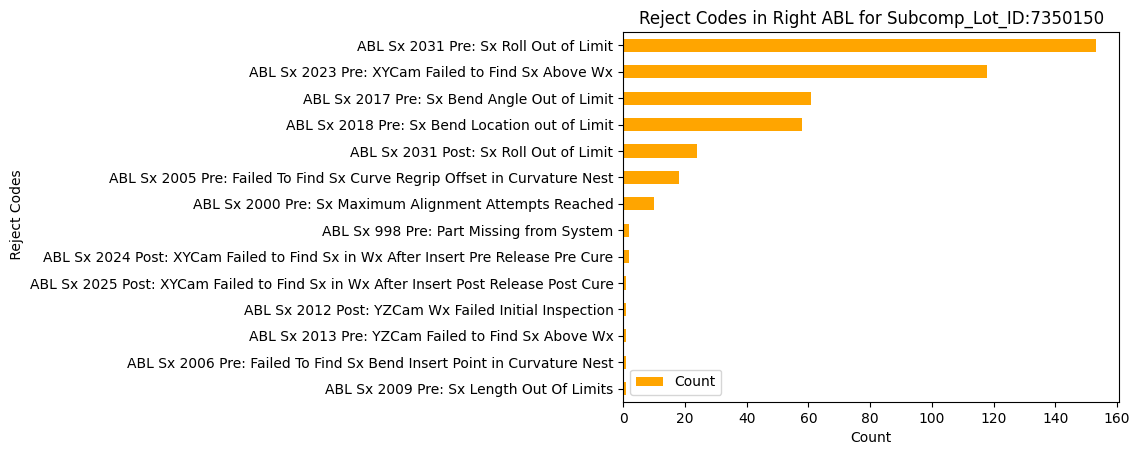

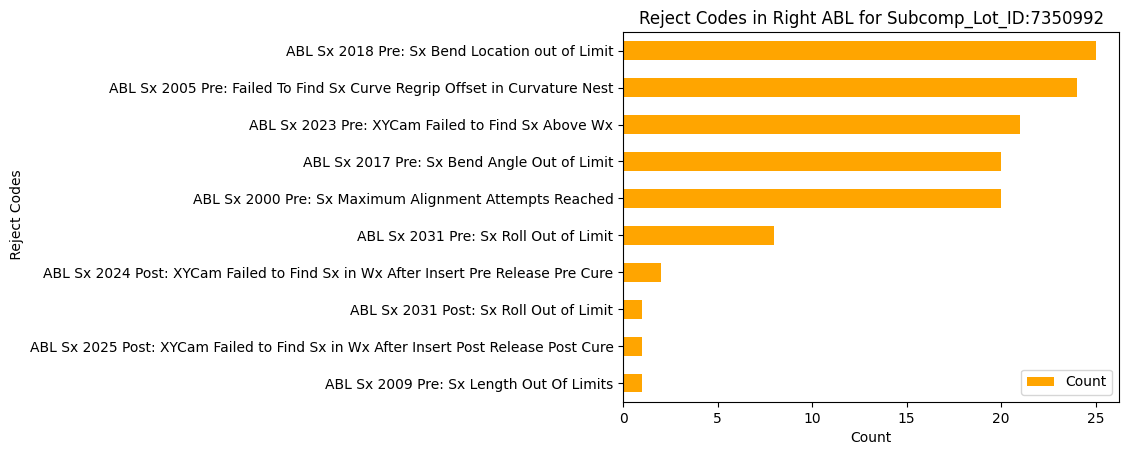

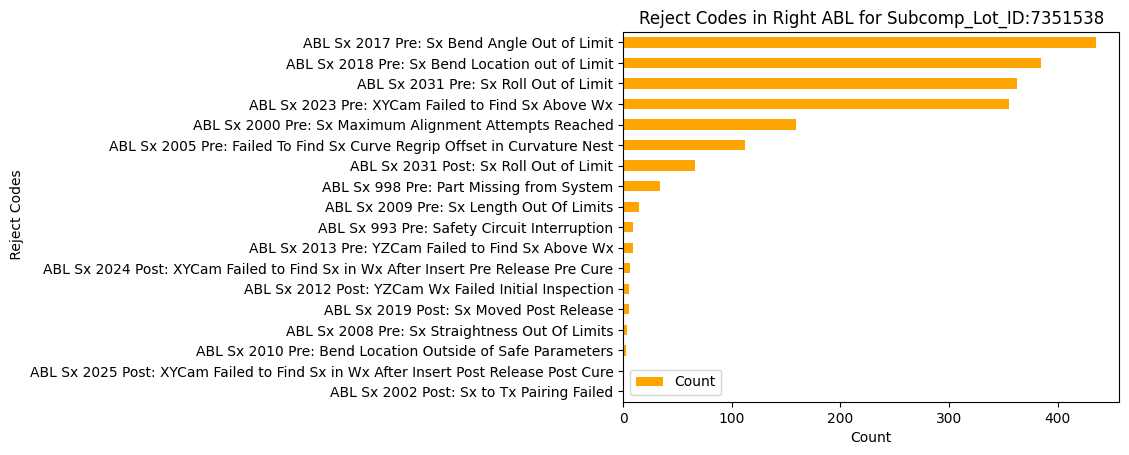

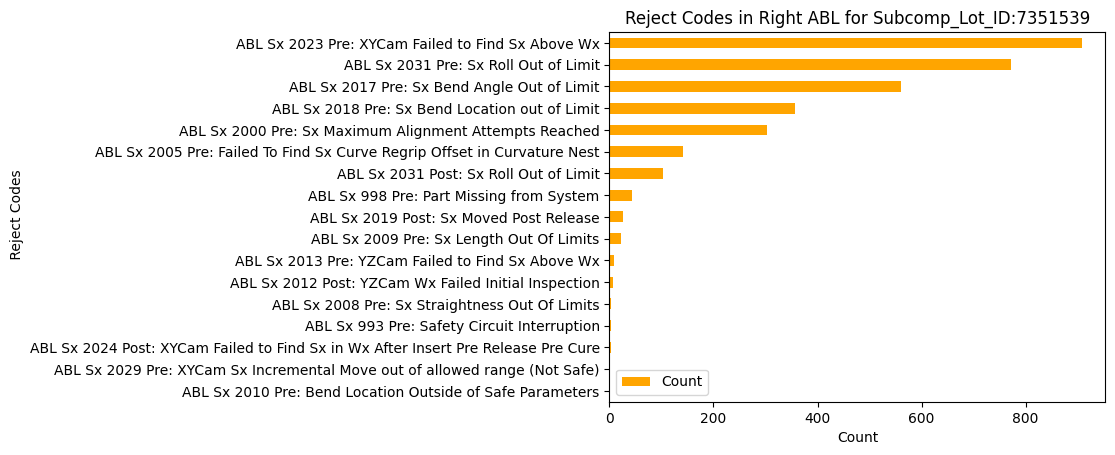

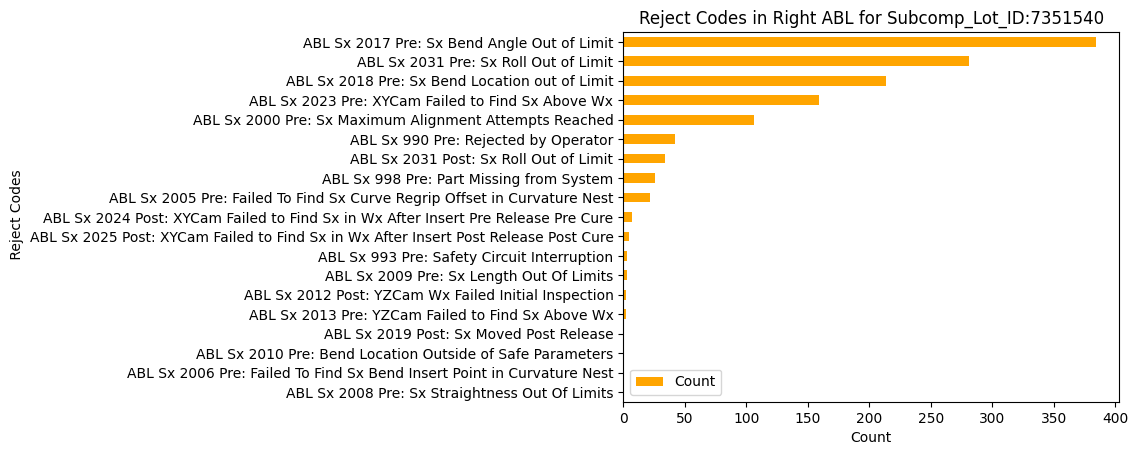

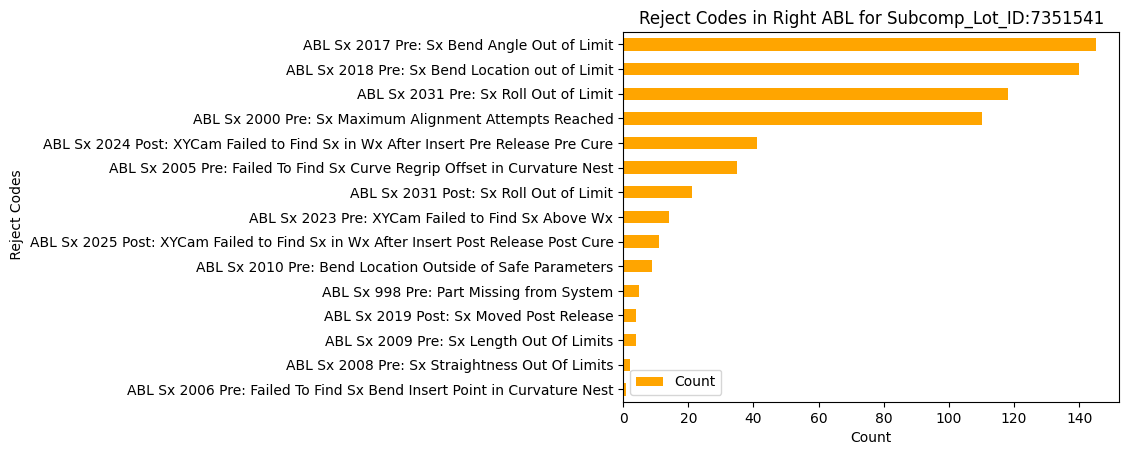

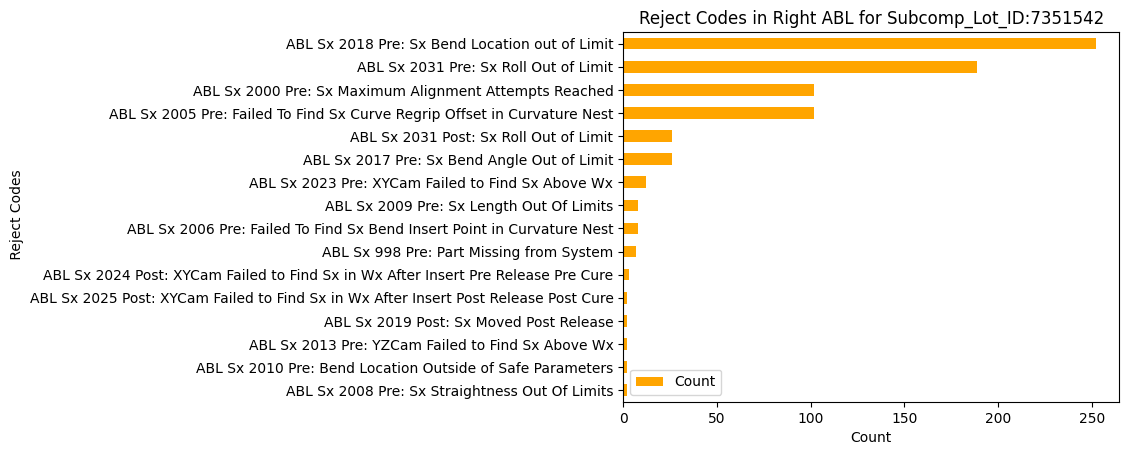

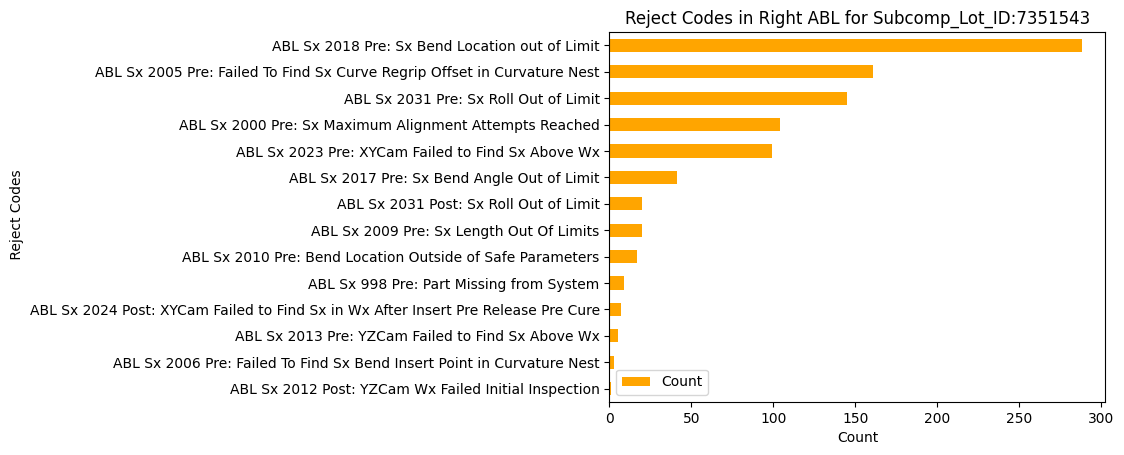

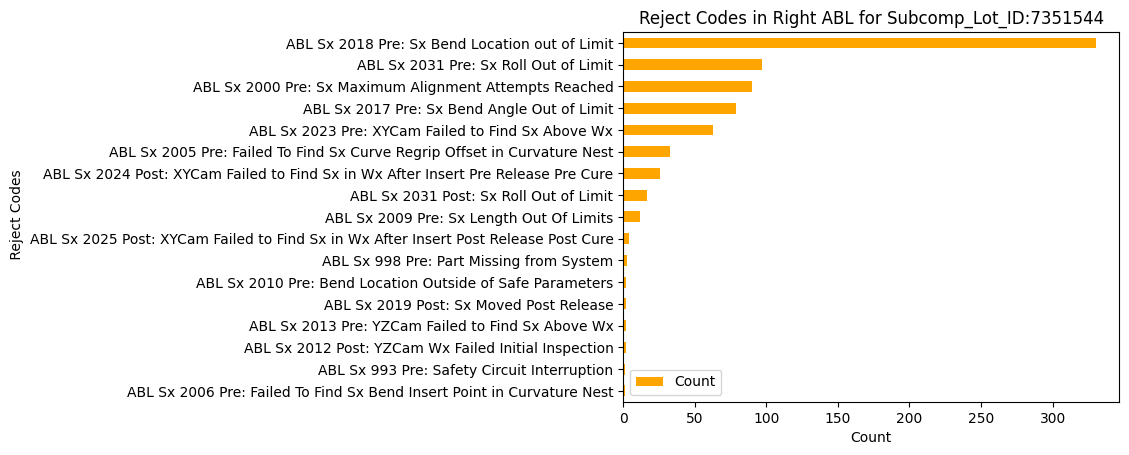

In [739]:
#Remove all Pass Codes so we are only left with reject codes for graphing
all_lines_reject_codes = merged_all_data[merged_all_data.get("Reject Code") != "Pass"]
#Change dataframe to count amount of each Reject Code by Subcomp_Lot_ID
all_lines_by_lot_reject_codes = all_lines_reject_codes.groupby(["Subcomp_Lot_ID", "Reject Code"]).count()
all_lines_by_lot_reject_codes.rename(columns = {"Timestamp": "Count"}, inplace = True)

#loop through each Subcomp_Lot_ID for graphing top error codes per Subcomp_Lot_ID
for Subcomp_Lot_ID in all_lines_by_lot_reject_codes.index.get_level_values("Subcomp_Lot_ID").unique():

    #sort reject codes by amount for each Subcomp_Lot_ID
    lot_reject_codes_sorted = all_lines_by_lot_reject_codes.loc[Subcomp_Lot_ID].sort_values(by = "Count", ascending = True)

    #plot sorted count reject codes
    lot_reject_codes_sorted.plot(
    kind="barh",
    y= "Count",
    color= "Orange",
    fontsize=10,
    title="Reject Codes in Right ABL for Subcomp_Lot_ID:" + str(Subcomp_Lot_ID),
    xlabel="Count",
    ylabel= " Reject Codes"
    );
    
all_lines_by_lot

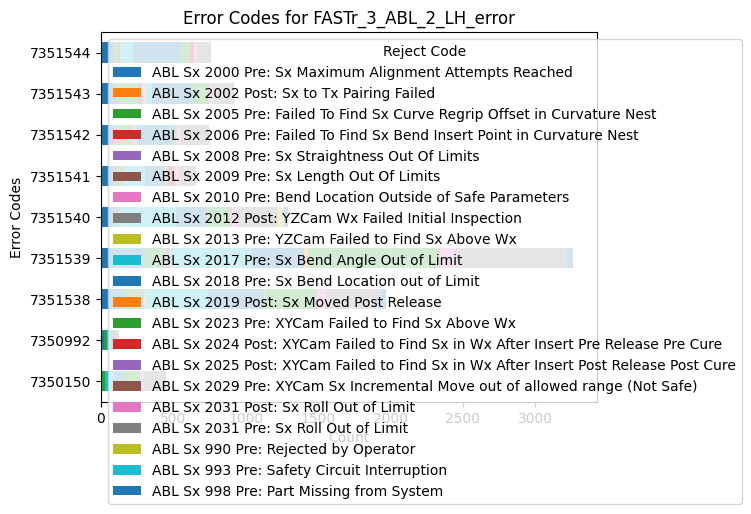

In [740]:
#Remove all Pass Codes so we are only left with reject codes for graphing
all_lines_reject_codes = merged_all_data[merged_all_data.get("Reject Code") != "Pass"]

#Groups by ID and turns unique Reject Codes into their own columns where each value under a reject code
#represents how often that error code occurs in that ID
Sub_Comp_ID_Reject_Codes = pd.crosstab(all_lines_reject_codes["Subcomp_Lot_ID"], all_lines_reject_codes["Reject Code"])

#Stores all unqiue reject codes which will be used to tell pandas what to graph in the plot below
unqiue_reject_codes = Sub_Comp_ID_Reject_Codes.columns.tolist()
#graph erros codes
Sub_Comp_ID_Reject_Codes.plot(
    kind="barh",
    stacked = True,
    y= unqiue_reject_codes,
    fontsize=10,
    title="Error Codes for " + error_array_names[int_index],
    xlabel="Count",
    ylabel="Error Codes"
    
);

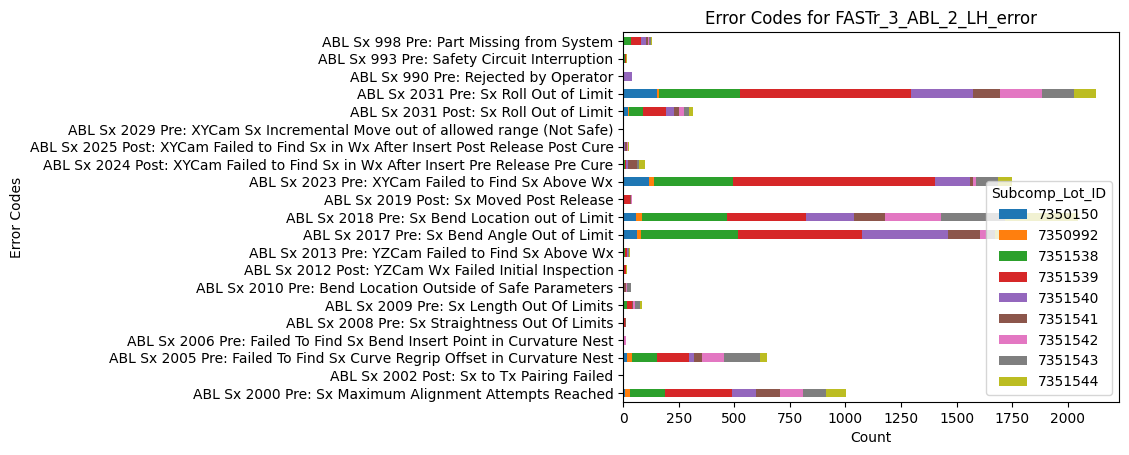

In [736]:
#Remove all Pass Codes so we are only left with reject codes for graphing
all_lines_reject_codes = merged_all_data[merged_all_data.get("Reject Code") != "Pass"]

#Groups by ID and turns unique Reject Codes into their own columns where each value under a reject code
#represents how often that error code occurs in that ID. Also sorts the dataframe
Sub_Comp_ID_Reject_Codes = pd.crosstab(all_lines_reject_codes["Reject Code"], all_lines_reject_codes["Subcomp_Lot_ID"])

#Stores all unqiue reject codes which will be used to tell pandas what to graph in the plot below
unqiue_reject_codes = Sub_Comp_ID_Reject_Codes.columns.tolist()

#graph erros codes
sorted_unqiue_reject_codes.plot(
    kind="barh",
    stacked = True,
    y= unqiue_reject_codes,
    fontsize=10,
    title="Error Codes for " + error_array_names[int_index],
    xlabel="Count",
    ylabel="Error Codes"
    
);